## Optimized texture calculation

Notebook showing optimization of texture calculation using matrix convolutions

In [1]:
import pyart
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time
from copy import deepcopy
import math
from scipy import ndimage, signal


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
radar_mcs_path = '/home/rjackson/data/radar/cpol/Gunn_pt_20060305121000ppi.nc'
radar_mcs = pyart.io.read(radar_mcs_path)

# Texture calculation via convolution

In the old methodology, the texture was calculated by using scipy's generic_filter and applying the angular standard deviation over a window.


The new methodology uses convolutions. The convolution operation of a matrix Y with its kernel X is.

$\begin{bmatrix}
    x_{11}       & x_{12} & x_{13} & \dots & x_{1n} \\
    x_{21}       & x_{22} & x_{23} & \dots & x_{2n} \\
    x_{m1}       & x_{m2} & x_{m3} & \dots & x_{mn}
\end{bmatrix} * \begin{bmatrix}
    y_{11}       & y_{12} & y_{13} & \dots & y_{1n} \\
    y_{21}       & y_{22} & y_{23} & \dots & y_{2n} \\
    y_{m1}       & y_{m2} & y_{m3} & \dots & y_{mn}
\end{bmatrix} [x_{ij}, y_{ij}] = \sum_{i=1}^{m} \sum_{j=1}^{n} x_{ij}y_{(m-i+1)(n-j+1)} $

To take the mean of a 3x3 window, we just convolve X = 3x3 matrix of ones with Y = 3x3 velocity window.

Therfore, to get the angular standard deviation, we first map the velocities into a phase space where -pi = -Nyquist and pi = Nyquist (from Py-ART code). The standard deviation is calculated from the norm of the window which is:

$N = (\bar{C}^{2} + \bar{S}^{2})^{1/2}$

Where C is the matrix containing the cosine of each entry in Y and S is the matrix containing the sine of each entry in Y.

To get the mean of C, we convolve C with X and divide that result by the convolution of X with itself. This is equivalent to adding each entry in C and dividing by the total number of entries.

Scipy's signal processing package has a routine convolve2d to do this very quickly.

Based off of std devation code in Py-ART.

In [3]:
# Use convolutions to calculate angular texture
def std_convoluted_radar(image, N, interval):
    # transform distribution from original interval to [-pi, pi]
    interval_max = interval[1]
    interval_min = interval[0]
    half_width = (interval_max - interval_min) / 2.
    center = interval_min + half_width
    
    # Calculate parameters needed for angular std. dev
    a = (np.asarray(image) - center) / (half_width) * np.pi
    im = a
    x = np.cos(im)
    y = np.sin(im)

    ones = np.ones(x.shape)
    
    # Calculate convolution
    kernel = np.ones((N, N))
    xs = signal.convolve2d(x, kernel, mode="same", boundary="symm")
    ys = signal.convolve2d(y, kernel, mode="same", boundary="symm")
    ns = N**2
    
    # Calculate norm over specified window
    xmean = xs/ns
    ymean = ys/ns
    norm = np.sqrt(xmean**2 + ymean**2)
    std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi
    return ndimage.filters.median_filter(std_dev, size=(N, N))

In [4]:
gatefilter = pyart.filters.GateFilter(radar_mcs)

nyq_Gunn = radar_mcs.instrument_parameters['nyquist_velocity']['data'][0]
bt = time.time()
data = ndimage.filters.generic_filter(radar_mcs.fields['velocity']['data'],
                                      pyart.util.interval_std, size = (4,4),
                                      extra_arguments = (-nyq_Gunn, nyq_Gunn))
filtered_data_old = ndimage.filters.median_filter(data, size = (4,4))
texture_field_old = pyart.config.get_metadata('velocity')
texture_field_old['data'] = filtered_data_old
radar_mcs.add_field('velocity_texture_old', 
                    texture_field_old, 
                    replace_existing = True)  
old_time = time.time()-bt
print('Time for old method:' + str(old_time))

bt = time.time()
filtered_data = std_convoluted_radar(radar_mcs.fields['velocity']['data'], 
                                     4, 
                                     (-nyq_Gunn, nyq_Gunn))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data
texture = texture_field['data']

radar_mcs.add_field('velocity_texture', 
                    texture_field, 
                    replace_existing = True) 
new_time = time.time()-bt
print('Time for new method:' + str(new_time))
print('The new method is ' + str(old_time/new_time) + ' times faster')

Time for old method:41.65143632888794


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in sqrt


Time for new method:0.7151687145233154
The new method is 58.24001453510177 times faster


{'coordinates': 'elevation azimuth range', 'long_name': 'Mean dopper velocity', 'standard_name': 'radial_velocity_of_scatterers_away_from_instrument', 'data': array([[ 4.32802898,  4.32802898,  6.36452865, ...,  5.20958557,
         3.92279762,  3.78323677],
       [ 4.32802898,  4.32802898,  6.36452865, ...,  5.21515724,
         4.01929792,  3.92279762],
       [ 4.59977074,  6.10957444,  6.94521832, ...,  6.50636832,
         5.58675357,  5.58675357],
       ..., 
       [ 7.683962  ,  7.08704285,  7.08704285, ...,         nan,
                nan,         nan],
       [ 7.67238462,  7.08704285,  6.47945126, ...,         nan,
                nan,         nan],
       [ 7.67238462,  7.08704285,  6.47945126, ...,         nan,
                nan,         nan]]), 'units': 'meters_per_second'}


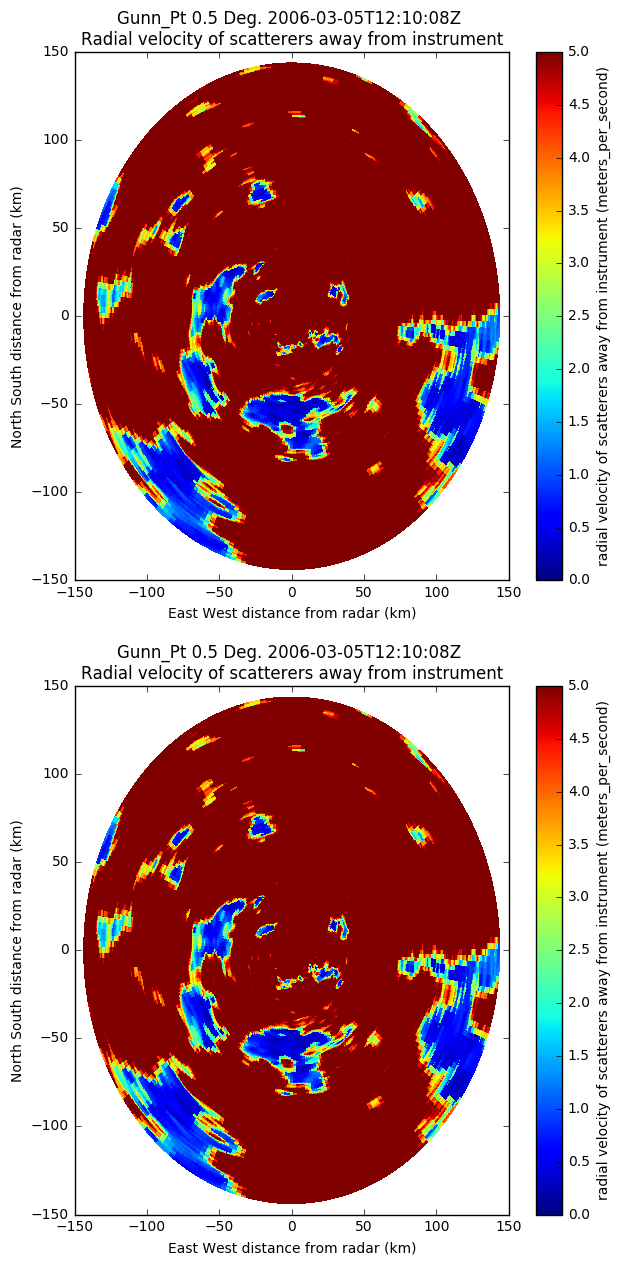

In [5]:
display_mcs = pyart.graph.RadarMapDisplay(radar_mcs)
plt.figure(figsize=(7,15))
plt.subplot(211)
display_mcs.plot_ppi('velocity_texture_old',  gatefilter=gatefilter, vmin=0, vmax=5)
plt.subplot(212)
display_mcs.plot_ppi('velocity_texture',  gatefilter=gatefilter, vmin=0, vmax=5)
print(texture_field)

/home/rjackson/.local/lib/python3.5/site-packages/pyart/util/sigmath.py:56: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi
/home/rjackson/.local/lib/python3.5/site-packages/pyart/util/sigmath.py:56: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi
/home/rjackson/.local/lib/python3.5/site-packages/pyart/util/sigmath.py:56: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi
/home/rjackson/.local/lib/python3.5/site-packages/pyart/util/sigmath.py:56: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi
/home/rjackson/.local/lib/python3.5/site-packages/pyart/util/sigmath.py:56: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi
/home/rjackson/.local/lib/python3.5/site-packages/pyart/util

0.701545000076294


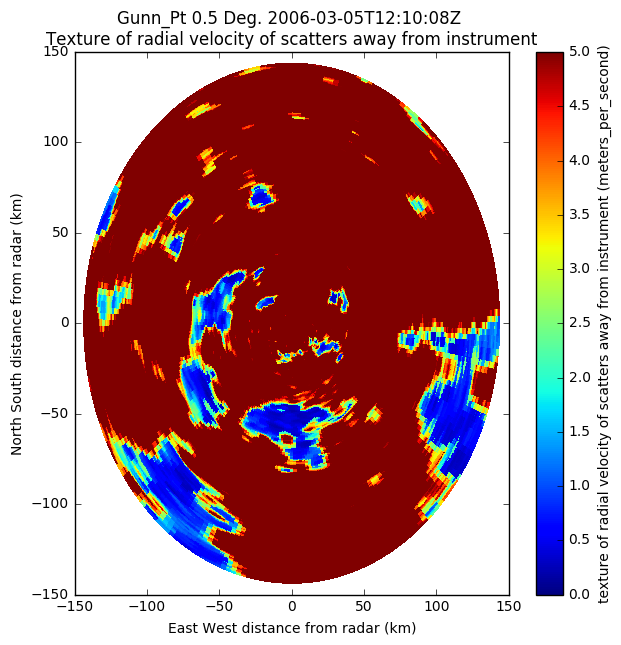

In [6]:
display_mcs = pyart.graph.RadarMapDisplay(radar_mcs)
vel_field = pyart.config.get_field_name('velocity')
plt.figure(figsize=(7,7))
bt = time.time()
new_texture = pyart.filters.calculate_velocity_texture(radar_mcs,
                                                       wind_size=4,
                                                       vel_field='velocity')
print(time.time()-bt)
radar_mcs.add_field('velocity_texture_new', 
                    new_texture, 
                    replace_existing = True) 
display_mcs.plot_ppi('velocity_texture_new', gatefilter=gatefilter, vmin=0, vmax=5)

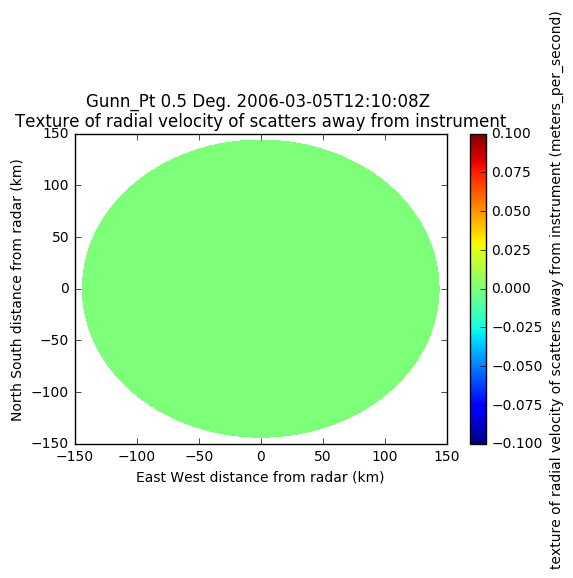

In [8]:
zero_velocity = np.zeros(texture_field['data'].shape)
zero_velocity_field = pyart.config.get_metadata('velocity')
zero_velocity_field['data'] = zero_velocity
radar_mcs.add_field('zero_velocity', 
                    zero_velocity_field, 
                    replace_existing = True) 
zero_texture = pyart.filters.calculate_velocity_texture(radar_mcs,
                                                        wind_size=3,
                                                        vel_field='zero_velocity')
radar_mcs.add_field('zero_texture', zero_texture, replace_existing=True)
display_mcs.plot_ppi('zero_texture')